## Code for reading the HAR-UML dataset

In [1]:
import numpy as np

from source.read_HAR_dataset import read_har_dataset, har_dimensions

In [3]:
# [X_train, y_train, epochs, X_test, y_test, test_epochs, X_validation, y_validation, validation_epochs, kcal_MET, test_kcal_MET, validation_kcal_MET] = 

data = read_har_dataset('./datasets/HAR-UML20/')

ids_train, X_train, y_train, I_train, train_kcal_MET = data['train']

ids_val, X_val, y_val, I_val, val_kcal_MET = data['val']

ids_test, X_test, y_test, I_test, test_kcal_MET = data['test']

Train IDS: [5, 2, 0, 7, 4, 1]
Test IDS: [6, 3]
Val IDS: [8, 9]
IDS: [5, 2, 0, 7, 4, 1, 6, 3, 8, 9]


In [26]:
def magnitude_pert(X_in, prange = (0, 1)):
    X = X_in.transpose([0, 2, 1])
    N, D, T = X.shape
    rand_mag = np.random.random([N, D]) * (prange[1] - prange[0]) + prange[0]
    rand_mag = np.repeat(rand_mag, T)
    rand_mag = rand_mag.reshape(N, D, T)
    return (X + rand_mag).transpose([0, 2, 1])

def time_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            time_warp = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps[i,:,dim])(orig_steps)
            scale = (x.shape[1]-1)/time_warp[-1]
            ret[i,:,dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[1]-1), pat[:,dim]).T
    return ret


X_aug = magnitude_pert(X_train, prange=(-10, 10))
# X_aug = time_warp(X_train)


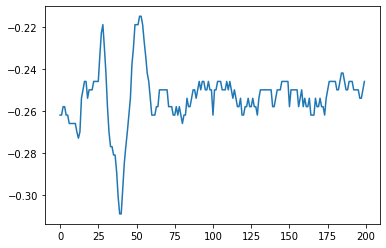

In [27]:
import matplotlib.pyplot as plt

plt.plot(X_train[2, :, 0])

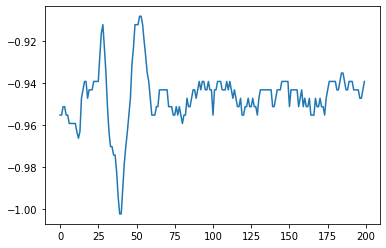

In [28]:
plt.plot(X_aug[2, :, 0])

In [11]:
har_dimensions

array(['Accelerometer-X', 'Accelerometer-Y', 'Accelerometer-Z',
       'Gyrometer-X', 'Gyrometer-Y', 'Gyrometer-Z', 'Magnetometer-X',
       'Magnetometer-Y', 'Magnetometer-Z'], dtype='<U15')

In [12]:
from source.utils import create_dir, filter_dimensions, save_metrics2
dimensions = [
    'Accelerometer-X', 
    'Accelerometer-Y',
    'Accelerometer-Z',
    'Gyrometer-X',
    'Gyrometer-Y',
    'Gyrometer-Z'
]

X_train_f = filter_dimensions(X_train, har_dimensions, dimensions)
X_test_f = filter_dimensions(X_test, har_dimensions, dimensions)
X_validation_f = filter_dimensions(X_val, har_dimensions, dimensions)

In [13]:
X_train_f.shape

(5460, 200, 6)

In [14]:
import sys
sys.path.insert(0, '/home/texs/Documents/VivaBem/repositories/ts2vec')
from ts2vec import TS2Vec

In [15]:
model = TS2Vec(
    input_dims=X_train_f.shape[2],
    device=0,
    output_dims=200
)
# print(train_data)
loss_log = model.fit(
    X_train_f,
    n_epochs=20,
    verbose=True
)

Epoch #0: loss=296.8211690715331
Epoch #1: loss=11.117479090816465
Epoch #2: loss=6.225528649920243
Epoch #3: loss=5.055363068482743


KeyboardInterrupt: 

In [ ]:
train_repr = model.encode(X_train_f.astype(np.float64), encoding_window='full_series')  # n_instances x output_dims
test_repr = model.encode(X_test_f.astype(np.float64), encoding_window='full_series')  # n_instances x output_dims

In [ ]:
import umap
reducer = umap.UMAP(n_components = 2)

# reducer.fit(train_repr, y=y_train)
reducer.fit(train_repr)

In [ ]:
train_coords = reducer.transform(train_repr)
test_coords = reducer.transform(test_repr)

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(train_coords[:, 0], train_coords[:, 1], c = y_train, cmap='jet')


In [ ]:
plt.scatter(test_coords[:, 0], test_coords[:, 1], c = y_test, cmap='jet')

In [ ]:
from source.classifiers import  lstm_classification

train_pred, test_pred, validation_pred =  lstm_classification(X_train_f, y_train, X_test_f, y_test, X_validation_f, y_validation, dimensions, 'har-lstm2', batch_size = 64, n_epochs=120)

In [ ]:
from source.utils import save_metrics

labels_map = {}
labels_map['lstm'] = [y_train, train_pred, y_test, test_pred, y_validation, validation_pred]

save_metrics(labels_map, "metrics_lstm.csv")

In [23]:
# test_pred[360:380]
# test_pred[360:380]
# y_test[320:340]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])